# ViEWS 3 ensembles: future predictions
UK FCDO Fatalities project, cm level

This notebook produces future predictions for a set of models defined in the list of dictionaries ModelList and the weights stored as iweights_df.csv. Both of these are produced by the notebook fatal_cm_compute_ensemble in this repository. 

The notebook draws on the following .py script files in this repository:

Ensembling.py

FetchData.py

HurdleRegression.py

It also requires the list of models included in the ensemble, in the following file:

EnsembleMetaData_cm_ + [run_id]

In [1]:
# Basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
# sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# Views 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
import views_dataviz
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
from views_forecasts.extensions import *

# Mapper
import geopandas as gpd

from views_dataviz.map import mapper, utils
from views_dataviz import color
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
#from ingester3.config import source_db_path

# Other packages
import pickle as pkl

#Parallelization
from joblib import Parallel, delayed, cpu_count
from functools import partial
from genetic2 import *

from pathlib import Path

# Predicting fatalities scripts
from HurdleRegression import *
from Ensembling import CalibratePredictions, RetrieveStoredPredictions, mean_sd_calibrated, gam_calibrated
from FetchData import FetchData, RetrieveFromList

Refreshing


In [39]:
# Common parameters:

dev_id = 'fatalities001'
run_id = 'fatalities001' 
EndOfHistory = 505
prod_id = '2022_01_t01'
#run_id = dev_id + '_' + prod_id
RunGeneticAlgo = False
level = 'cm'
WriteToOverleaf = True

steps = [*range(1, 36+1, 1)] # Which steps to train and predict for

#steps = [1,2,3,4,5,6,7,8,9,10,11,12,15,18,21,24] # Which steps to train and predict for
#fi_steps = [1,3,6,12,36] # Which steps to present feature importances for
#steps = [1,12,24,36]
fi_steps = [1,3,6,12,36]
#steps = [1,6,36]
#fi_steps = [1,6,36]

# Specifying partitions

calib_partitioner_dict = {"train":(121,396),"predict":(397,444)}
test_partitioner_dict = {"train":(121,444),"predict":(445,492)}
future_partitioner_dict = {"train":(121,492),"predict":(493,504)}
calib_partitioner =  views_runs.DataPartitioner({"calib":calib_partitioner_dict})
test_partitioner =  views_runs.DataPartitioner({"test":test_partitioner_dict})
future_partitioner =  views_runs.DataPartitioner({"future":future_partitioner_dict})

# Specifying paths - note these have to be set to conform to individual setups!

Mydropbox = '/Users/angli742/Dropbox (ViEWS)/ViEWS/'
localgitpath = '/Users/angli742/ViEWS3/'

if WriteToOverleaf:
    overleafpath = f'/Users/angli742/Dropbox (ViEWS)/ViEWS/DataReleases/OverleafSync/{run_id}_{prod_id}'

# Mydropbox = '/Users/havardhegre/Dropbox (ViEWS)/ViEWS/',
#    localgitpath = '/Users/havardhegre/views3/',    
    
# if WriteToOverleaf:,
#        if EndOfHistory==508:,
#            overleafpath = '/Users/havardhegre/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/',
#        if EndOfHistory==509:,
#            overleafpath = '/Users/havardhegre/Dropbox (ViEWS)/Apps/Overleaf/ViEWS_Presentations_2021/Figures/Forecasts/Apr2022/',


# Retrieve models and predictions

In [3]:

gitname = 'EnsembleMetaData_cm_' + dev_id + '.csv'
EnsembleMetaData = pd.read_csv(gitname)
ModelList = EnsembleMetaData.to_dict('records')
i = 0
for model in ModelList:
    print(i, model['modelname'])
    i = i + 1

0 fat_baseline_rf
1 fat_conflicthistory_srf
2 fat_conflicthistory_gbm
3 fat_conflicthistory_hurdle_lgb
4 fat_conflicthistory_long_xgb
5 fat_vdem_hurdle_xgb
6 fat_wdi_rf
7 fat_topics_rf
8 fat_topics_histgbm
9 fat_broad_xgb
10 fat_greatest_hits_hurdle_xgb
11 fat_hh20_hurdle_lgb
12 fat_all_pca3_xgb
13 fat_topics_pca3_lgb
14 fat_hh20_Markov_glm
15 fat_hh20_Markov_rf


# Retrieve and calibrate predictions and data

In [4]:
## Running and saving David's models
# Import subprocess to run Rscript
import subprocess

# Fetch and save data (can perhaps be simplified?)
qs = Queryset('hh_20_features','country_month')
qs.fetch().to_parquet('markov/tmp.parquet')

# Set commands and arguments. R-scripts located in 'Markov'-folder
command ='Rscript'
path2script ='markov/omm_ranger_hh20_fcdo_py.R'
cmd = [command, path2script]
data_path = localgitpath + 'FCDO_predicting_fatalities/markov/' + 'tmp.parquet'
save_path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'
args = [str(EndOfHistory),data_path,save_path]

# Run subprocess. Saves the predictions as csv-files to the save_path location with prefix vmm_[estimator]_hh20_[EndOfHistory]
subprocess.call(cmd+args)


 .    

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──
✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘magrittr’

The following object is masked from ‘package:purrr’:

    set_names

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘arrow’

The following object is masked from ‘package:magrittr’:

    is_in

The following object is masked from ‘package:utils’:

    timestamp




 All required packages installed 

 Packages loaded, starting script 
50.018 sec elapsed
1 
41.714 sec elapsed
2 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


42.412 sec elapsed
3 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


39.052 sec elapsed
4 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


44.248 sec elapsed
5 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


36.822 sec elapsed
6 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


48.584 sec elapsed
7 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


54.006 sec elapsed
8 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


49.515 sec elapsed
9 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


44.701 sec elapsed
10 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


55.213 sec elapsed
11 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


55.305 sec elapsed
12 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


39.031 sec elapsed
13 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


51.504 sec elapsed
14 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


37.779 sec elapsed
15 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


53.312 sec elapsed
16 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


48.536 sec elapsed
17 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


57.83 sec elapsed
18 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


56.312 sec elapsed
19 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


44.602 sec elapsed
20 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


46.065 sec elapsed
21 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


57.366 sec elapsed
22 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


56.689 sec elapsed
23 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


38.775 sec elapsed
24 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


55.316 sec elapsed
25 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


39.26 sec elapsed
26 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


51.93 sec elapsed
27 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


38.566 sec elapsed
28 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


55.647 sec elapsed
29 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


47.552 sec elapsed
30 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


45.408 sec elapsed
31 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


48.037 sec elapsed
32 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


53.12 sec elapsed
33 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


39.933 sec elapsed
34 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


58.539 sec elapsed
35 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")


35.432 sec elapsed
36 


Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
Joining, by = c("month_id", "country_id")
There were 50 or more warnings (use warnings() to see the first 50)


0

In [5]:
# Retrieve David's models from dropbox and store in prediction storage
path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

DRList = [
    {
        'modelname': 'fat_hh20_Markov_glm',
        'filename': path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
    },
    
    {
        'modelname': 'fat_hh20_Markov_rf',
        'filename': path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
    }
]
    
for model in DRList:
    df_future = pd.read_csv(model['filename'],index_col=['month_id','country_id'])
    df_future['ln_ged_sb_dep'] = np.nan # Empty dependent variable column for consistency/required by prediction storage function
    stored_modelname = level + '_' + model['modelname'] + '_f' + str(EndOfHistory)
    df_future.forecasts.set_run(run_id)
    df_future.forecasts.to_store(name=stored_modelname, overwrite=True)    

In [6]:
# Retrieving the predictions for calibration and test partitions
# The ModelList contains the predictions organized by model

ModelList = RetrieveStoredPredictions(ModelList, steps, EndOfHistory, run_id)

ModelList = CalibratePredictions(ModelList, EndOfHistory, steps)

0 fat_baseline_rf
pr_45_cm_fat_baseline_rf_calib.parquet
pr_45_cm_fat_baseline_rf_test.parquet
1 fat_conflicthistory_srf
pr_45_cm_fat_conflicthistory_srf_calib.parquet
pr_45_cm_fat_conflicthistory_srf_test.parquet
2 fat_conflicthistory_gbm
pr_45_cm_fat_conflicthistory_gbm_calib.parquet
pr_45_cm_fat_conflicthistory_gbm_test.parquet
3 fat_conflicthistory_hurdle_lgb
pr_45_cm_fat_conflicthistory_hurdle_lgb_calib.parquet
pr_45_cm_fat_conflicthistory_hurdle_lgb_test.parquet
4 fat_conflicthistory_long_xgb
pr_45_cm_fat_conflicthistory_long_xgb_calib.parquet
pr_45_cm_fat_conflicthistory_long_xgb_test.parquet
5 fat_vdem_hurdle_xgb
pr_45_cm_fat_vdem_hurdle_xgb_calib.parquet
pr_45_cm_fat_vdem_hurdle_xgb_test.parquet
6 fat_wdi_rf
pr_45_cm_fat_wdi_rf_calib.parquet
pr_45_cm_fat_wdi_rf_test.parquet
7 fat_topics_rf
pr_45_cm_fat_topics_rf_calib.parquet
pr_45_cm_fat_topics_rf_test.parquet
8 fat_topics_histgbm
pr_45_cm_fat_topics_histgbm_calib.parquet
pr_45_cm_fat_topics_histgbm_test.parquet
9 fat_broad_x

In [7]:
# Run querysets and postprocessing (e.g. PCA) to obtain data for future prediction
# Returns as 'Datasets'; a list of dataframes
Datasets = FetchData(dev_id)

Fetching data using querysets; returns as list of dictionaries containing datasets
 .    baseline: A dataset with 6 columns, with data between t = 1 and 852; 213 units.
 .    conflictlong_ln: A dataset with 58 columns, with data between t = 1 and 852; 213 units.
 .    conflict_ln: A dataset with 29 columns, with data between t = 1 and 852; 213 units.
 .    conflict_nolog: A dataset with 29 columns, with data between t = 1 and 852; 213 units.
 .    wdi_short: A dataset with 32 columns, with data between t = 1 and 852; 213 units.
 .    vdem_short: A dataset with 63 columns, with data between t = 1 and 852; 213 units.
 .    topics_short: A dataset with 39 columns, with data between t = 1 and 852; 213 units.
 .    broad: A dataset with 110 columns, with data between t = 1 and 852; 213 units.
 .    gh: A dataset with 59 columns, with data between t = 1 and 852; 213 units.
 .    hh20: A dataset with 39 columns, with data between t = 1 and 852; 213 units.
 .    all_features: A dataset with 18

In [8]:
len(Datasets)

15

In [9]:


from views_runs import Storage, StepshiftedModels
from views_partitioning.data_partitioner import DataPartitioner
from viewser import Queryset, Column
from views_runs import operations
from views_runs.run_result import RunResult

from pygam import LogisticGAM, LinearGAM, s, te

RewritePredictions = True # Set this to True to rewrite predictions even if they exist

def RetrainAndPredict(modelname):
    force_retrain = False
    modelstore = storage.Storage()
    # Predictions for true future
    ct = datetime.now()
    print('Future', ct)
    modelstore = storage.Storage()
    model['RunResult_future']  = RunResult.retrain_or_retrieve(
            retrain            = force_retrain,
            store              = modelstore,
            partitioner        = DataPartitioner({"test":future_partitioner_dict}),
            stepshifted_models = StepshiftedModels(model['algorithm'], steps, model['depvar']),
            dataset            = RetrieveFromList(Datasets,model['data_train']),
            queryset_name      = model['queryset'],
            partition_name     = "test",
            timespan_name      = "train",
            storage_name       = model['modelname'] + '_future',
            author_name        = "HH",
    )       
    predictions_future = model['RunResult_future'].run.future_point_predict(EndOfHistory,model['RunResult_future'].data)
    return predictions_future



i = 0
print('Computing predictions, production run ' + prod_id + ', development run ' + run_id)
for model in ModelList:

    # Loop that checks whether (1) this a model trained outside the main system, 
    # (2) retrieves the prediction if it exists in prediction storage,
    # (3) if not checks whether the trained model exists, retrains if not, 
    # Then calibrates the predictions and stores them if they have not been stored before for this run.
    # To do: set the data_preprocessing to the function in the model dictionary
    
    model['predstorename_ncal'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
    model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

    
    if 'Markov' not in model['modelname']: # Only Markov models are currently exceptions
        print(i, model['modelname'])

        ct = datetime.now()
        print('Trying to retrieve non-calibrated predictions', ct)
        if RewritePredictions:
            model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])
        else:
            try:
                model['future_df_noncalibrated'] = pd.DataFrame.forecasts.read_store(run=run_id, name=model['predstorename_ncal'])
                print('Predictions for ', model['predstorename_ncal'], ', run', run_id, 'exist, retrieving from prediction storage')

            except KeyError:
                print(model['predstorename_ncal'], ', run', run_id, 'does not exist, predicting')
                model['future_df_noncalibrated'] = RetrainAndPredict(model['predstorename_ncal'])

        # Calibrating and storing   
        # Storing non-calibrated
        
        model['future_df_noncalibrated'].forecasts.set_run(run_id)
        model['future_df_noncalibrated'].forecasts.to_store(name=model['predstorename_ncal'], overwrite=True)   
        print('Calibrating')
        model['future_df_calibrated'] = model['future_df_noncalibrated'].copy()
        for step in steps:
            thismonth = EndOfHistory + step
            
            model['future_df_calibrated'].loc[thismonth,'step_combined'] = pd.DataFrame(model['calibration_gams'][step-1]['calibration_GAM'].predict(model['future_df_noncalibrated'].loc[thismonth])).values
         # Storing calibrated
        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   
            
    else: # If one of David's Markov models
        print(i, model['modelname'])
            
        model['predstorename_noncalibrated'] = level +  '_' + model['modelname'] + '_noncalibrated' + '_f' + str(EndOfHistory)
        print(model['predstorename_noncalibrated'], ', run', run_id, 'is being retrieved from dropbox')
        path = Mydropbox + 'Projects/PredictingFatalities/Predictions/cm/preds/'

        if model['modelname'] == 'fat_hh20_Markov_glm':
            DR_filename = path + 'vmm_glm_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
        if model['modelname'] == 'fat_hh20_Markov_rf':
            DR_filename = path + 'vmm_rf_hh20_' + str(EndOfHistory) + '.csv'
            model['future_df_calibrated'] = pd.read_csv(DR_filename,index_col=['month_id','country_id'])
            
        model['predstorename_cal'] = level +  '_' + model['modelname'] + '_calibrated' + '_f' + str(EndOfHistory)

        model['future_df_calibrated'].forecasts.set_run(run_id)
        model['future_df_calibrated'].forecasts.to_store(name=model['predstorename_cal'], overwrite=True)   


    i = i + 1

print('All done')
        
        

Computing predictions, production run 2022_01_t01, development run fatalities001
0 fat_baseline_rf
Trying to retrieve non-calibrated predictions 2022-06-23 14:21:29.134442
Future 2022-06-23 14:21:29.714515
 * == Performing a run: "fat_baseline_rf_future" == * 
Model object named "fat_baseline_rf_future" with equivalent metadata already exists.
Fetching "fat_baseline_rf_future" from storage
Calibrating
1 fat_conflicthistory_srf
Trying to retrieve non-calibrated predictions 2022-06-23 14:21:37.774756
Future 2022-06-23 14:21:37.832067
 * == Performing a run: "fat_conflicthistory_srf_future" == * 
Model object named "fat_conflicthistory_srf_future" with equivalent metadata already exists.
Fetching "fat_conflicthistory_srf_future" from storage
Calibrating
2 fat_conflicthistory_gbm
Trying to retrieve non-calibrated predictions 2022-06-23 14:23:35.832596
Future 2022-06-23 14:23:35.882472
 * == Performing a run: "fat_conflicthistory_gbm_future" == * 
Model object named "fat_conflicthistory_gbm

In [10]:
Datasets[8]['df']['ste_theta0']

month_id  country_id
1         1             0.002525
          2             0.012168
          3             0.018992
          4             0.004650
          5             0.012554
                          ...   
852       242           0.070848
          243           0.049041
          244           0.073166
          245           0.164494
          246           0.188125
Name: ste_theta0, Length: 158230, dtype: float64

In [11]:
#df = RetrieveFromList(Datasets,model['data_train'])
model['data_train']

'hh20'

In [12]:
EnsembleList = [] # Separate list of dictionaries for ensembles!

Ensemble = {
    'modelname':            'genetic_ensemble',
    'algorithm':            [],
    'depvar':               'ln_ged_sb_dep',
    'data_train':           [],
    'Algorithm_text':       '',
    'calibration_gams':     [],
    'future_df_calibrated': [],
}
EnsembleList.append(Ensemble)


In [13]:
# Collecting in one df, one column per model
ConstituentModels_df = pd.DataFrame(ModelList[0]['future_df_calibrated']['step_combined'])
ConstituentModels_df.columns = [ModelList[0]['modelname']]
for model in ModelList[1:]:
    ConstituentModels_df[model['modelname']] = pd.DataFrame(model['future_df_calibrated']['step_combined'])


In [14]:
# Retrieve genetic algorithm results
i_weights_df = pd.read_csv('GeneticWeights.csv')

# Retrieve ensemble predictions for test partition to create categorical predictions

In [15]:
stored_modelname_test = level + '_' + 'ensemble_genetic' + '_test'

ensemble_test_df = pd.DataFrame.forecasts.read_store(stored_modelname_test, run=run_id)
ensemble_test_df.replace([np.inf, -np.inf], 0, inplace=True)  

ensemble_test_df.head()

pr_45_cm_ensemble_genetic_test.parquet


ln_ged_sb_dep  step_pred_1  step_pred_2  step_pred_3  \
month_id country_id                                                         
445      1                     0.0     0.005563     0.004951     0.012528   
         2                     0.0     0.005697     0.005027     0.008652   
         3                     0.0     0.004972     0.003582     0.008594   
         4                     0.0     0.006677     0.005719     0.017421   
         5                     0.0     0.004958     0.003926     0.027564   

                     step_pred_4  step_pred_5  step_pred_6  step_pred_7  \
month_id country_id                                                       
445      1              0.006011     0.011841     0.008146     0.013653   
         2              0.005641     0.006289     0.007599     0.010050   
         3              0.004545     0.005442     0.005802     0.007202   
         4              0.007139     0.011609     0.015981     0.029109   
         5              0.004944     0.005961     0.006788     0.008557   

                     step_pred_8  step_pred_9  ...  step_pred_27  \
month_id country_id                            ...                 
445      1              0.030181     0.042033  ...      0.071926   
         2              0.033353     0.053311  ...      0.035227   
         3              0.026234     0.027537  ...      0.027428   
         4              0.075062     0.017399  ...      0.059749   
         5              0.030704     0.020028  ...      0.039151   

                     step_pred_28  step_pred_29  step_pred_30  step_pred_31  \
month_id country_id                                                           
445      1               0.077772      0.105595      0.103998      0.130841   
         2               0.041752      0.052451      0.039233      0.042370   
         3               0.035304      0.039094      0.037283      0.041144   
         4               0.070128      0.072224      0.080133      0.076579   
         5               0.044097      0.058967      0.047277      0.049376   

                     step_pred_32  step_pred_33  step_pred_34  step_pred_35  \
month_id country_id                                                           
445      1               0.117213      0.153186      0.110771      0.122282   
         2               0.040896      0.040162      0.039304      0.050947   
         3               0.038301      0.037016      0.035603      0.044332   
         4               0.099174      0.090635      0.085778      0.080696   
         5               0.050611      0.048259      0.053024      0.056818   

                     step_pred_36  
month_id country_id                
445      1               0.126573  
         2               0.061960  
         3               0.055101  
         4               0.120929  
         5               0.060505  

[5 rows x 37 columns]

In [16]:
# Generate dichotomous version of dependent variable
ensemble_test_df['ged_gte_25'] = ensemble_test_df['ln_ged_sb_dep'].apply(lambda x: 1 if x >= np.log1p(25) else 0)
# Generate multiclass version for uncertainty estimation
def ged_categorical(x):
    if x < np.log1p(0.5):
        return 0
    elif x < np.log1p(10):
        return 1
    elif x < np.log1p(100):
        return 2
    elif x < np.log1p(1000):
        return 3
    else :
        return 4

ensemble_test_df['ged_multi'] = ensemble_test_df['ln_ged_sb_dep'].apply(ged_categorical)

ensemble_test_df.describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,step_pred_29,step_pred_30,step_pred_31,step_pred_32,step_pred_33,step_pred_34,step_pred_35,step_pred_36,ged_gte_25,ged_multi
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000
mean,0.498353,0.560980,0.618191,0.662192,0.659004,0.666390,0.691495,0.683195,0.699126,0.726877,...,0.831314,0.823146,0.836206,0.830228,0.821270,0.829181,0.828891,0.830216,0.075698,0.291121
std,1.368332,1.404679,1.485336,1.518213,1.544874,1.528754,1.598157,1.560446,1.555519,1.633281,...,1.729052,1.731811,1.739331,1.728791,1.697003,1.722374,1.725747,1.726073,0.264529,0.766228
min,0.000000,0.003473,0.003368,-0.056081,-0.137353,-0.497818,-0.143848,0.000400,0.007705,0.004381,...,-0.165348,-0.012017,0.011888,-0.121196,-0.157935,-0.011901,0.005127,0.035276,0.000000,0.000000
25%,0.000000,0.005620,0.005754,0.020882,0.007224,0.009395,0.011802,0.014283,0.032870,0.037410,...,0.055737,0.044750,0.049494,0.050073,0.046909,0.049176,0.056184,0.064082,0.000000,0.000000
50%,0.000000,0.008277,0.013994,0.060491,0.020825,0.028036,0.036646,0.050735,0.073470,0.076191,...,0.088595,0.077555,0.088895,0.088819,0.092501,0.098184,0.096388,0.100431,0.000000,0.000000
75%,0.000000,0.064690,0.162397,0.215736,0.201416,0.222522,0.244624,0.227523,0.244160,0.266229,...,0.386792,0.401416,0.388763,0.395720,0.426932,0.412998,0.396613,0.385979,0.000000,0.000000
max,8.698181,8.908706,10.152814,9.938714,11.894818,10.710877,10.344631,10.324780,11.477252,12.685356,...,9.927775,9.984045,9.891022,10.047450,10.106808,10.104843,10.215712,10.212896,1.000000,4.000000


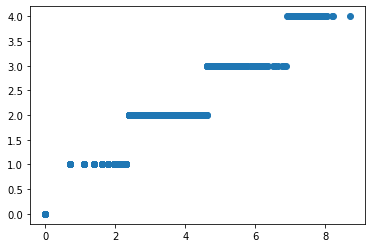

In [17]:
plt.scatter(ensemble_test_df['ln_ged_sb_dep'],ensemble_test_df['ged_multi'])

In [18]:
# Train model to transform predictions from  fatalities to (1) dichotomous and (2) multiclass
from sklearn.linear_model import LogisticRegression
dichotomous_classifiers = []
multi_classifiers = []
for step in steps:
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Dichotomous
    y_dich = np.array(ensemble_test_df['ged_gte_25']).reshape(-1, 1)
    dich_clf = LogisticRegression(random_state=0).fit(X, y_dich)
    dichotomous_classifiers.append(dich_clf)
    p_dich = dich_clf.predict_proba(X)
    ensemble_test_df['dich_step_{step}_logit'] = p_dich[:,1].ravel()
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    p_multi = multi_clf.predict_proba(X)
    for cls in [0,1,2,3,4]:
        ensemble_test_df[f'multi_{cls}_step_{step}_logit'] = p_multi[:,cls].ravel()

ensemble_test_df.describe()

,ln_ged_sb_dep,step_pred_1,step_pred_2,step_pred_3,step_pred_4,step_pred_5,step_pred_6,step_pred_7,step_pred_8,step_pred_9,...,multi_0_step_35_logit,multi_1_step_35_logit,multi_2_step_35_logit,multi_3_step_35_logit,multi_4_step_35_logit,multi_0_step_36_logit,multi_1_step_36_logit,multi_2_step_36_logit,multi_3_step_36_logit,multi_4_step_36_logit
count,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,9168.000000,...,9.168000e+03,9168.000000,9168.000000,9168.000000,9.168000e+03,9.168000e+03,9168.000000,9168.000000,9168.000000,9.168000e+03
mean,0.498353,0.560980,0.618191,0.662192,0.659004,0.666390,0.691495,0.683195,0.699126,0.726877,...,8.509004e-01,0.046793,0.071220,0.022469,8.616568e-03,8.508943e-01,0.046793,0.071226,0.022470,8.616927e-03
std,1.368332,1.404679,1.485336,1.518213,1.544874,1.528754,1.598157,1.560446,1.555519,1.633281,...,2.928094e-01,0.069804,0.160837,0.073740,7.017838e-02,2.902597e-01,0.068094,0.158951,0.072680,6.903313e-02
min,0.000000,0.003473,0.003368,-0.056081,-0.137353,-0.497818,-0.143848,0.000400,0.007705,0.004381,...,1.660065e-08,0.000585,0.005864,0.000139,3.385823e-09,2.485246e-08,0.000643,0.006787,0.000202,2.882488e-09
25%,0.000000,0.005620,0.005754,0.020882,0.007224,0.009395,0.011802,0.014283,0.032870,0.037410,...,9.613212e-01,0.016424,0.006441,0.000157,4.072247e-09,9.602166e-01,0.017257,0.007146,0.000216,3.197730e-09
50%,0.000000,0.008277,0.013994,0.060491,0.020825,0.028036,0.036646,0.050735,0.073470,0.076191,...,9.755093e-01,0.017319,0.006934,0.000172,4.708872e-09,9.739928e-01,0.018086,0.007626,0.000234,3.644922e-09
75%,0.000000,0.064690,0.162397,0.215736,0.201416,0.222522,0.244624,0.227523,0.244160,0.266229,...,9.769668e-01,0.025392,0.011992,0.000348,1.388278e-08,9.753662e-01,0.025643,0.012665,0.000446,1.015977e-08
max,8.698181,8.908706,10.152814,9.938714,11.894818,10.710877,10.344631,10.324780,11.477252,12.685356,...,9.786941e-01,0.292504,0.614750,0.451641,8.813521e-01,9.764033e-01,0.286062,0.611846,0.430138,8.991997e-01


# Calculating and storing ensemble future predictions

In [19]:
# Setting up a placeholder df for ensemble predictions
EnsembleList[0]['future_df_calibrated'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline
EnsembleList[0]['future_df_dichotomous'] = ModelList[0]['future_df_calibrated'].copy() # Copy from baseline

ConstituentModels_df_w = ConstituentModels_df.copy()

for step in steps:
    month = EndOfHistory + step
    weightcol = 'step_pred_' + str(step)
    weights = np.array(pd.DataFrame(i_weights_df[weightcol]))
    EnsembleList[0]['future_df_calibrated'].loc[month] = ConstituentModels_df_w.loc[month].dot(weights).values
    x_d = np.array(EnsembleList[0]['future_df_calibrated'].loc[month]).reshape(-1,1)
    pred_step = dichotomous_classifiers[step-1].predict_proba(x_d)
    EnsembleList[0]['future_df_dichotomous']['step_combined'].loc[month] = pred_step[:,1]

In [20]:
# Storing the ensemble future predictions
predstore_future = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory)
EnsembleList[0]['future_df_calibrated'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_calibrated'].forecasts.to_store(name=predstore_future, overwrite = True) 
predstore_future_dich = level +  '_' + EnsembleList[0]['modelname'] + '_dich_f' + str(EndOfHistory)
EnsembleList[0]['future_df_dichotomous'].forecasts.set_run(run_id)
EnsembleList[0]['future_df_dichotomous'].forecasts.to_store(name=predstore_future_dich, overwrite = True) 


In [21]:
ViewsMetadata().with_name('genetic').fetch()

,id,name,file_name,runs_id,model_generations_id,user_name,spatial_loa,temporal_loa,ds,osa,time_min,time_max,space_min,space_max,steps,target,prediction_columns,date_written,description,deleted
0,1137,cm_ensemble_genetic_f505,pr_33_cm_ensemble_genetic_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-03-19 08:09:49.362072+00:00,None,False
1,12013,cm_ensemble_genetic_exp_exp_calib,pr_33_cm_ensemble_genetic_exp_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:27.861484+00:00,None,False
2,12014,cm_ensemble_genetic_exp_exp_test,pr_33_cm_ensemble_genetic_exp_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:21:34.024314+00:00,None,False
3,12017,cm_ensemble_genetic_exp_calib,pr_33_cm_ensemble_genetic_exp_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:40:57.763694+00:00,None,False
4,12018,cm_ensemble_genetic_exp_test,pr_33_cm_ensemble_genetic_exp_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-26 10:41:06.365460+00:00,None,False
5,12110,cm_genetic_ensemble_f503,pr_33_cm_genetic_ensemble_f503.parquet,33,1,hh,c,m,False,False,504,539,1,246,[],step_combined,[],2022-04-27 06:28:50.198353+00:00,None,False
6,12141,cm_genetic_ensemble_f505,pr_33_cm_genetic_ensemble_f505.parquet,33,1,hh,c,m,False,False,506,541,1,246,[],step_combined,[],2022-04-27 06:50:05.853414+00:00,None,False
7,12173,cm_ensemble_genetic_calib,pr_33_cm_ensemble_genetic_calib.parquet,33,1,hh,c,m,False,True,397,444,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:18.202727+00:00,None,False
8,12174,cm_ensemble_genetic_test,pr_33_cm_ensemble_genetic_test.parquet,33,1,hh,c,m,False,True,445,492,1,246,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",ln_ged_sb_dep,"[step_pred_1, step_pred_10, step_pred_11, step...",2022-04-28 10:27:26.273595+00:00,None,False
9,12716,cm_genetic_ensemble_f506,pr_33_cm_genetic_ensemble_f506.parquet,33,1,jim,c,m,False,False,507,542,1,246,[],step_combined,[],2022-05-09 16:10:06.894731+00:00,None,False


# Mapping future predictions

In [22]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

from views_dataviz import color
from views_dataviz.map import utils
from views_dataviz.map.presets import ViewsMap

import sqlalchemy as sa
#from ingester3.config import source_db_path
#from ingester3.Country import Country
#from ingester3.extensions import *
#from ingester3.ViewsMonth import ViewsMonth

import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd
import numpy as np

class Mapper2:
    """
    `Map` takes basic properties and allows the user to consecutively add
    layers to the Map object. This makes it possible to prepare mapping
    "presets" at any level of layeredness that can be built on further.
    
    Mapper2 allows for the customizable addition of scaling to the map. 
    -re-add the code for labels later when i can test it

    Attributes
    ----------
    width: Integer value for width in inches.
    height: Integer value for height in inches.
    bbox: List for the bbox per [xmin, xmax, ymin, ymax].
    frame_on: Bool for whether to draw a frame around the map.
    title: Optional default title at matplotlib's default size.
    figure: Optional tuple of (fig, size) to use if you want to plot into an
        already existing fig and ax, rather than making a new one.
    """

    def __init__(
        self,
        width,
        height,
        bbox=None,
        cmap=None,
        frame_on=True,
        title="",  # Default title without customization. (?)
        figure=None,
    ):
        self.width = width
        self.height = height
        self.bbox = bbox  # xmin, xmax, ymin, ymax
        self.cmap = cmap
        if figure is None:
            self.fig, self.ax = plt.subplots(figsize=(self.width, self.height))
        else:
            self.fig, self.ax = figure
        self.texts = []
        self.ax.set_title(title)

        if frame_on:  # Remove axis ticks only.
            self.ax.tick_params(
                top=False,
                bottom=False,
                left=False,
                right=False,
                labelleft=False,
                labelbottom=False,
            )
        else:
            self.ax.axis("off")

        if bbox is not None:
            self.ax.set_xlim((self.bbox[0], self.bbox[1]))
            self.ax.set_ylim((self.bbox[2], self.bbox[3]))

    def add_layer(self, gdf, map_scale=False, map_dictionary=False, cmap=None, inform_colorbar=False, **kwargs):
        """Add a geopandas plot to a new layer.

        Parameters
        ----------
        gdf: Geopandas GeoDataFrame to plot.
        cmap: Optional matplotlib colormap object or string reference
            (e.g. "viridis").
        inform_colorbar: Set or overwrite colorbar with the current layer.
            Not applicable when `color` is supplied in the kwargs.
        map_scale: set a manual scale for the map. If missing defaults to the Remco procedure. 
        map_dictionary: set manual labels for the map. If missing defaults to the default labels.
        **kwargs: Geopandas `.plot` keyword arguments.
        """
        if "color" in kwargs:
            colormap = None
        else:
            colormap = self.cmap if cmap is None else cmap
            if inform_colorbar and "column" in kwargs:
                if hasattr(self, "cax"):
                    self.cax.remove()
                if "vmin" not in kwargs:
                    self.vmin = gdf[kwargs["column"]].min()
                else:
                    self.vmin = kwargs["vmin"]
                if "vmax" not in kwargs:
                    self.vmax = gdf[kwargs["column"]].max()
                else:
                    self.vmax = kwargs["vmax"]
        
        try: Mapper2.add_colorbar(self, colormap, min(map_scale), max(map_scale))
        except: Mapper2.add_colorbar(self, colormap, self.vmin, self.vmax)
        
        try:
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, vmin=min(map_scale), vmax=max(map_scale), **kwargs)
        except: 
            self.ax = gdf.plot(ax=self.ax, cmap=colormap, **kwargs)

                
        return self
    
    def add_colorbar(
        self,
        cmap,
        vmin,
        vmax,
        location="right",
        size="5%",
        pad=0.1,
        alpha=1,
        labelsize=16,
        tickparams=None,
    ):
        """Add custom colorbar to Map.

        Needed since GeoPandas legend and plot axes do not align, see:
        https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html

        Parameters
        ----------
        cmap: Matplotlib colormap object or string reference (e.g. "viridis").
        vmin: Minimum value of range colorbar.
        vmax: Maximum value of range colorbar.
        location: String for location of colorbar: "top", "bottom", "left"
            or "right".
        size: Size in either string percentage or number of pixels.
        pad: Float for padding between the plot's frame and colorbar.
        alpha: Float for alpha to apply to colorbar.
        labelsize: Integer value for the text size of the ticklabels.
        tickparams: Dictionary containing value-label pairs. For example:
            {0.05: "5%", 0.1: "10%"}
        """
        norm = plt.Normalize(vmin, vmax)
        if isinstance(cmap, str):
            cmap = plt.get_cmap(cmap)
        cmap = color.force_alpha_colormap(cmap=cmap, alpha=alpha)
        scalar_to_rgba = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        divider = make_axes_locatable(self.ax)
        self.cax = divider.append_axes(location, size, pad)
        self.cax.tick_params(labelsize=labelsize)
        tickvalues = (
            list(tickparams.keys()) if tickparams is not None else None
        )
        self.cbar = plt.colorbar(
            scalar_to_rgba, cax=self.cax, ticks=tickvalues
        )
        if tickparams is not None:
            self.cbar.set_ticklabels(list(tickparams.values()))
        return self
    
    def save(
        self, path, dpi=200, **kwargs
    ):  # Just some defaults to reduce work.
        """Save Map figure to file.
        Parameters
        ----------
        path: String path, e.g. "./example.png".
        dpi: Integer dots per inch. Increase for higher resolution figures.
        **kwargs: Matplotlib `savefig` keyword arguments.
        """
        self.fig.savefig(path, dpi=dpi, bbox_inches="tight", **kwargs)
        plt.close(self.fig)
        
def vid2date(i):
    year=str(1980 + i//12)
    month=str(i%12)
    return year+'/'+month
        
#def vid2date(i):
#    year=str(ViewsMonth(i).year)
#    month=str(ViewsMonth(i).month)
#    return year+'/'+month

#note the zip function occured earlier
standard_scale = [np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300), np.log1p(1000), np.log1p(3000),  np.log1p(10000)]
standard_scale_labels = ['0', '3','10', '30','100', '300', '1000', '3000', '10000']

small_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100),  np.log1p(300), np.log1p(1000)]


small_scale_labels = ['0', '3','10', '30','100', '300', '1000']

small_scale_nolabels = ['', '','', '','', '', '']

In [23]:
# Prepare the gdf
gdf_base = gpd.read_parquet('./geometry/cm_geometry.parquet')
gdf = gdf_base.copy()

In [25]:
# Future prediction maps, predictions, rolling
path = Mydropbox + 'DataReleases/MonthlyUpdates/{run_id}_{prod_id}'
stepstoplot=[3,5,8,12,24,36]
#titles = [vid2date(i) for i in stepstoplot + EndOfHistory]


df = EnsembleList[0]['future_df_calibrated'].copy()
gdf2 = gdf_base.copy()
df = df.join(gdf2.set_index("country_id"))
gdf3 = gpd.GeoDataFrame(df, geometry="geom")

In [26]:
for step in stepstoplot:
        month = step + EndOfHistory
        gdf = gdf3.loc[month]
        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Ensemble predictions as of ' + vid2date(EndOfHistory+step) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf,
        map_scale=standard_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column='step_combined', 
        inform_colorbar=True
        )
        m.cbar.set_ticks(standard_scale)
        m.cbar.set_ticklabels(standard_scale_labels)
        if WriteToOverleaf:
            m.save(f'{overleafpath}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')
#        except:
#            print('Overleaf/dropbox folder not found')
        m.save(f'{path}PredictionMap_cm_ensemble_standard_scale_r{EndOfHistory}_m{month}.png')

# Line graphs for individual countries

In [27]:
def CumulativeFatalities(df,steps):
    ''' Calculates the sum of (real-space) fatalities in the step_combined column '''
    # Loop over all steps 
    df['exp']=np.rint(np.expm1(df['step_combined'][0:steps+1]))
    return df['exp'].sum()
    

genetic_ensemble
Algeria 3 months:  4 12 months:  17 , 36 months:57
Angola 3 months:  1 12 months:  6 , 36 months:28
Bahrain 3 months:  0 12 months:  0 , 36 months:0
Benin 3 months:  6 12 months:  22 , 36 months:91
Botswana 3 months:  0 12 months:  0 , 36 months:0
Burkina Faso 3 months:  1101 12 months:  1902 , 36 months:4276
Burundi 3 months:  9 12 months:  37 , 36 months:102
Cameroon 3 months:  139 12 months:  432 , 36 months:1269
Central African Republic 3 months:  202 12 months:  494 , 36 months:911
Chad 3 months:  15 12 months:  51 , 36 months:196
Congo 3 months:  0 12 months:  0 , 36 months:7
Cote d'Ivoire 3 months:  0 12 months:  2 , 36 months:25
Djibouti 3 months:  0 12 months:  0 , 36 months:0
DRCongo 3 months:  881 12 months:  2009 , 36 months:5227
Egypt 3 months:  38 12 months:  161 , 36 months:667
Equatorial Guinea 3 months:  0 12 months:  0 , 36 months:1
Eritrea 3 months:  0 12 months:  0 , 36 months:0
Eswatini 3 months:  0 12 months:  0 , 36 months:0
Ethiopia 3 months:  4

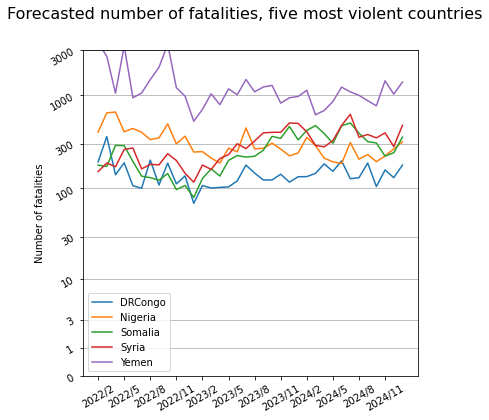

In [28]:
from matplotlib import cm

#ModelSelection = [1,3,5,9,11]

plt.rcParams["figure.figsize"] = (6, 6)
path = Mydropbox + 'DataReleases/MonthlyUpdates/{run_id}_{prod_id}'

log_scale_value = np.array([np.log1p(0), np.log1p(1), np.log1p(3), np.log1p(10), np.log1p(30), np.log1p(100),np.log1p(300),np.log1p(1000),np.log1p(3000)])
log_scale_naming = ['0','1','3','10','30','100','300','1000','3000']
month_value = np.arange(EndOfHistory+1, EndOfHistory+36, 3).tolist()
month_name = []
for m in month_value:
    month_name.append(vid2date(m))

first_month = EndOfHistory

CountryList = [
    ('Algeria',67,5000),
    ('Angola',165,500),
    ('Bahrain',127,500),
    ('Benin',74,500),
    ('Botswana',154,500),
    ('Burkina Faso',47,2000),
    ('Burundi',155,2000),
    ('Cameroon',69,2000),
    ('Central African Republic',70,2000),
    ('Chad',214,2000),
    ('Congo',166,2000),
    ('Cote d\'Ivoire',41,2000),
    ('Djibouti',55,500),
    ('DRCongo',167,20000),
    ('Egypt',222,5000),
    ('Equatorial Guinea',76,2000),
    ('Eritrea',56,500),
    ('Eswatini',164,500),
    ('Ethiopia',57,2000),
    ('Gabon',169,500),
    ('The Gambia',54,500),
    ('Ghana',42,500),
    ('Guinea',48,500),
    ('Guinea-Bissau',49,500),
    ('Iran',128,2000),
    ('Iraq',60,2000),
    ('Israel',218,2000),
    ('Jordan',62,2000),
    ('Kenya',237,2000),
    ('Lebanon',94,2000),
    ('Lesotho',160,2000),
    ('Liberia',43,2000),
    ('Libya',213,5000),
    ('Madagascar',172,500),
    ('Malawi',161,2000),
    ('Mali',50,20000),
    ('Mauritania',244,500),
    ('Morocco',243,500),
    ('Mozambique',162,2000),
    ('Namibia',170,500),
    ('Niger',78,2000),
    ('Nigeria',79,20000),
    ('Oman',119,2000),
    ('Qatar',130,2000),
    ('Rwanda',156,2000),
    ('Saudi Arabia',131,500),
    ('Senegal',52,500),
    ('Sierra Leone',53,500),
    ('Somalia',120,20000),
    ('South Africa',163,2000),
    ('South Sudan',246,5000),
    ('Sudan',245,2000),
    ('Syria',220,50000),
    ('Tanzania',242,500),
    ('Togo',81,500),
    ('Turkey',96,2000),
    ('Uganda',235,2000),
    ('United Arab Emirates',132,500),
    ('Yemen',124,20000),
    ('Zambia',157,2000),
    ('Zimbabwe',158,5000),
]


df = EnsembleList[0]['future_df_calibrated'].copy()
totals36 = []
totals12 = []
totals6 = []
totals3 = []
totals = []

model = EnsembleList[-1]

print(model['modelname'])
# Calculate non-logged and cumulative series
for cnt in CountryList:
    plt.clf()
#        print(cnt)
    sc_df = EnsembleList[0]['future_df_calibrated'].xs(cnt[1],level=1)
    print(cnt[0], '3 months: ', "{:.0f}".format(CumulativeFatalities(sc_df,3)), '12 months: ', "{:.0f}".format(CumulativeFatalities(sc_df,12)), ', 36 months:' "{:.0f}".format(CumulativeFatalities(sc_df,36)))
    totals36.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,36)})
    totals12.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,12)})
    totals6.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,6)})
    totals3.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,3)})
    t = []
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,36)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,12)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,6)})
    t.append({'Country': cnt[0], 'Fatalities': CumulativeFatalities(sc_df,3)})
    totals.append(t)
    months = sc_df.index.to_series()
    sc_df_exp = sc_df.copy()
    plt.plot(months, 'step_combined', data=sc_df)
    plt.suptitle('Forecasted number of fatalities, ' + cnt[0], fontsize=16)
    plt.title('Total for 36-month period from ' + vid2date(EndOfHistory+1) + ' to ' + vid2date(EndOfHistory+36) +': ' +  "{:.0f}".format(CumulativeFatalities(sc_df,36)), fontsize=12)
    plt.ylabel('Number of fatalities')
    plt.yticks(log_scale_value, log_scale_naming, rotation=30)
    plt.xticks(month_value, month_name, rotation=30)
    plt.grid(axis='y')
    plt.ylim([0,np.log1p(3000)])
    filename = path + 'LineGraph_' + model['modelname'] + '_' + cnt[0] + '_r' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)
    if cnt[0] == 'Ethiopia' or cnt[0] == 'Nigeria' or cnt[0] == 'DRCongo' or cnt[0] == 'Somalia' or cnt[0] == 'Yemen' or cnt[0] == 'Syria':
        if WriteToOverleaf:
            filename = overleafpath + 'LineGraph_' + model['modelname'] + '_' + cnt[0] + '_r' + str(EndOfHistory) + '.png'
            plt.savefig(filename, dpi=300)
        
# Collecting five top countries in one graph
plt.clf()
for cnt in CountryList:
    if cnt[0] == 'Nigeria' or cnt[0] == 'DRCongo' or cnt[0] == 'Somalia' or cnt[0] == 'Yemen' or cnt[0] == 'Syria':
        sc_df = EnsembleList[0]['future_df_calibrated'].xs(cnt[1],level=1)
        months = sc_df.index.to_series()
        sc_df_exp = sc_df.copy()
        plt.plot(months, 'step_combined', data=sc_df, label = cnt[0])
plt.suptitle('Forecasted number of fatalities, five most violent countries', fontsize=16)
plt.ylabel('Number of fatalities')
plt.yticks(log_scale_value, log_scale_naming, rotation=30)
plt.xticks(month_value, month_name, rotation=30)
plt.grid(axis='y')
plt.ylim([0,np.log1p(3000)])
plt.legend()
filename = path + 'LineGraph_' + model['modelname'] + '_' + 'Top5' + '_r' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'LineGraph_' + model['modelname'] + '_' + 'Top5' + '_r' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

totals36_df = pd.DataFrame(totals36)
totals36_df['Fatalities'] = totals36_df['Fatalities'].astype(int)
totals12_df = pd.DataFrame(totals12)
totals12_df['Fatalities'] = totals12_df['Fatalities'].astype(int)
totals6_df = pd.DataFrame(totals6)
totals6_df['Fatalities'] = totals6_df['Fatalities'].astype(int)
totals3_df = pd.DataFrame(totals3)
totals3_df['Fatalities'] = totals3_df['Fatalities'].astype(int)
totals_df = pd.DataFrame(totals)
#totals12_df['Fatalities'] = totals12_df['Fatalities'].astype(int)

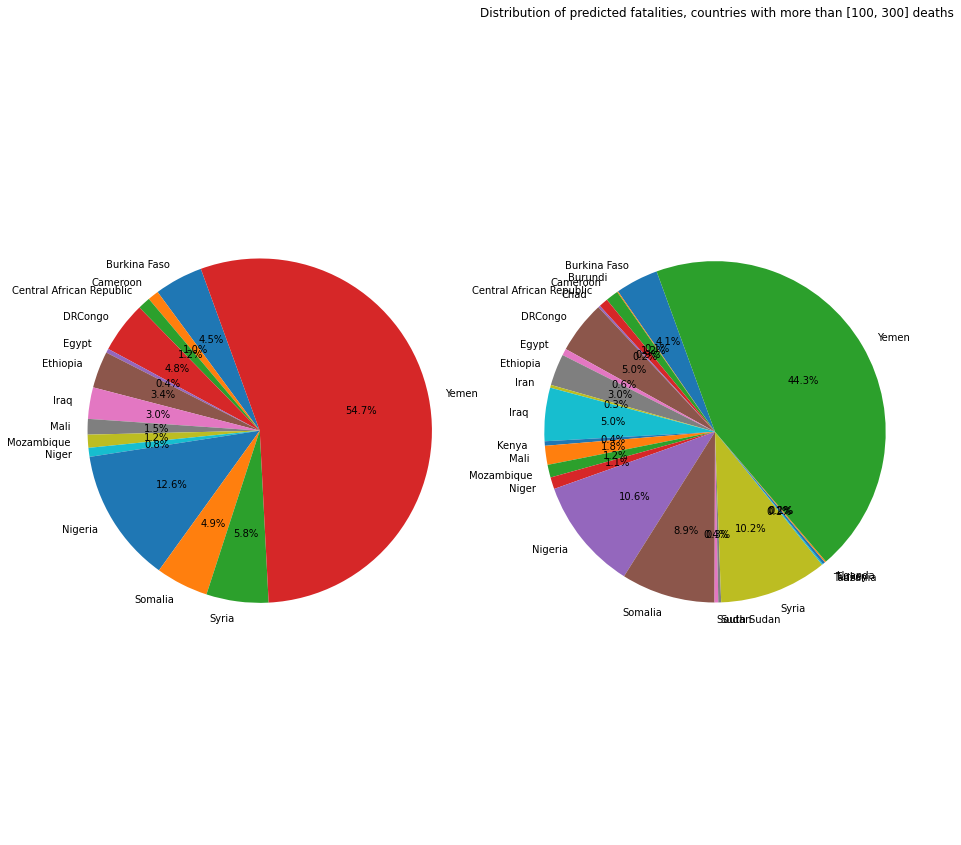

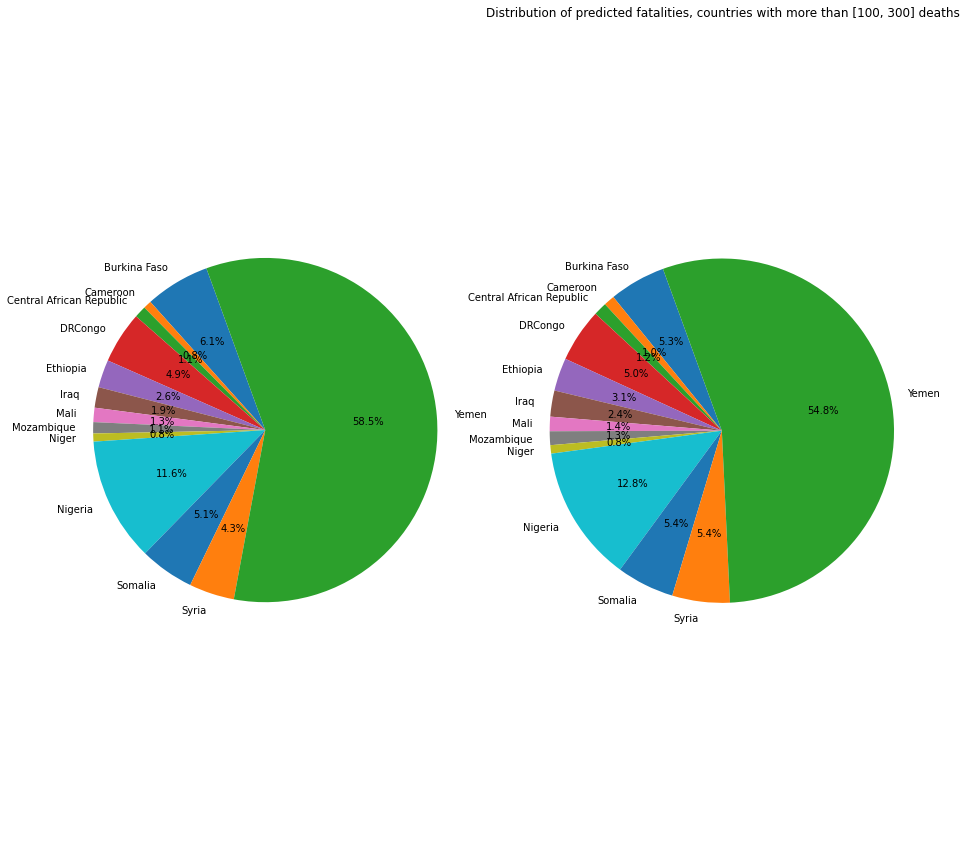

In [29]:
# Pie chart for total predicted fatalities over next 36 months
MinimumFatalities = [100,300]

totals3_subset = totals3_df.loc[(totals3_df['Fatalities'] >= MinimumFatalities[0])]
labels3 = totals3_subset['Country']
sizes3 = totals3_subset['Fatalities']


totals6_subset = totals6_df.loc[(totals6_df['Fatalities'] >= MinimumFatalities[0])]
labels6 = totals6_subset['Country']
sizes6 = totals6_subset['Fatalities']


totals12_subset = totals12_df.loc[(totals12_df['Fatalities'] >= MinimumFatalities[0])]
labels12 = totals12_subset['Country']
sizes12 = totals12_subset['Fatalities']

totals36_subset = totals36_df.loc[(totals36_df['Fatalities'] >= MinimumFatalities[0])]
labels36 = totals36_subset['Country']
sizes36 = totals36_subset['Fatalities']

# Figure for 12 and 36 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.pie(sizes12, labels=labels12, autopct='%1.1f%%', shadow=False, startangle=110, radius=5000)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(sizes36, labels=labels36, autopct='%1.1f%%', shadow=False, startangle=110)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.title('Distribution of predicted fatalities, countries with more than ' + str(MinimumFatalities) + ' deaths')

filename = path + 'TotalsPie_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsPie_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

# Figure for 3 and 6 months
fig2,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.pie(sizes3, labels=labels3, autopct='%1.1f%%', shadow=False, startangle=110, radius=5000)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

ax2.pie(sizes6, labels=labels6, autopct='%1.1f%%', shadow=False, startangle=110)
ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.


plt.title('Distribution of predicted fatalities, countries with more than ' + str(MinimumFatalities) + ' deaths')

filename = path + 'TotalsPie_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsPie_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

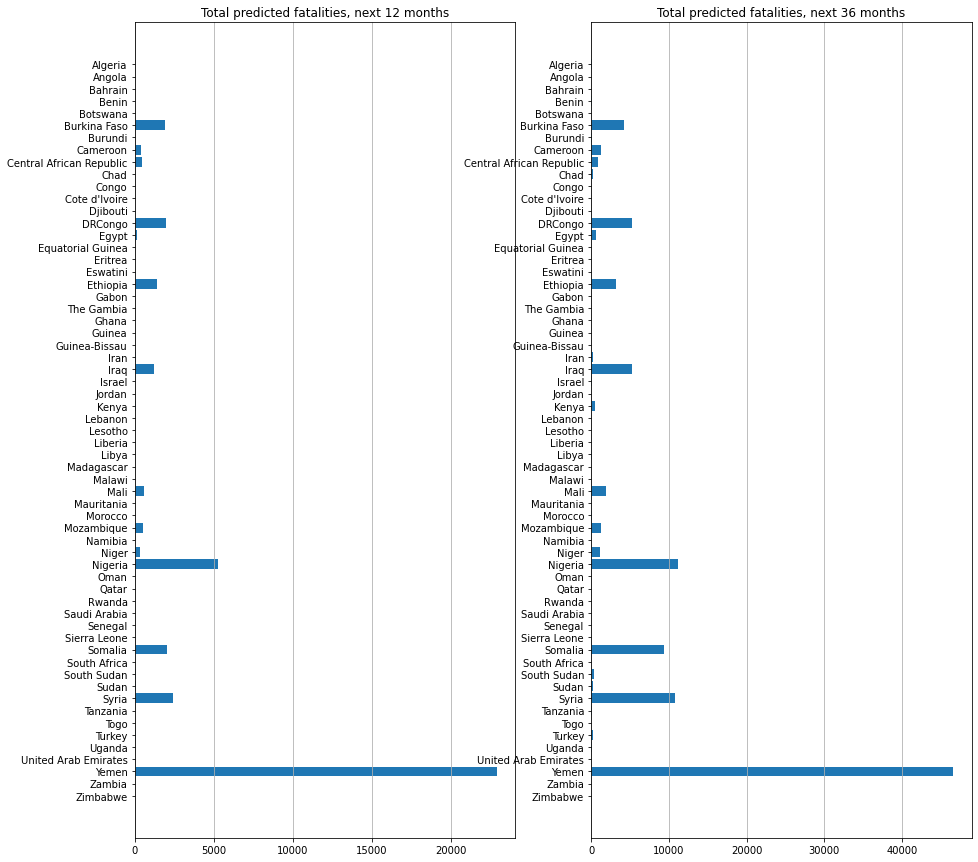

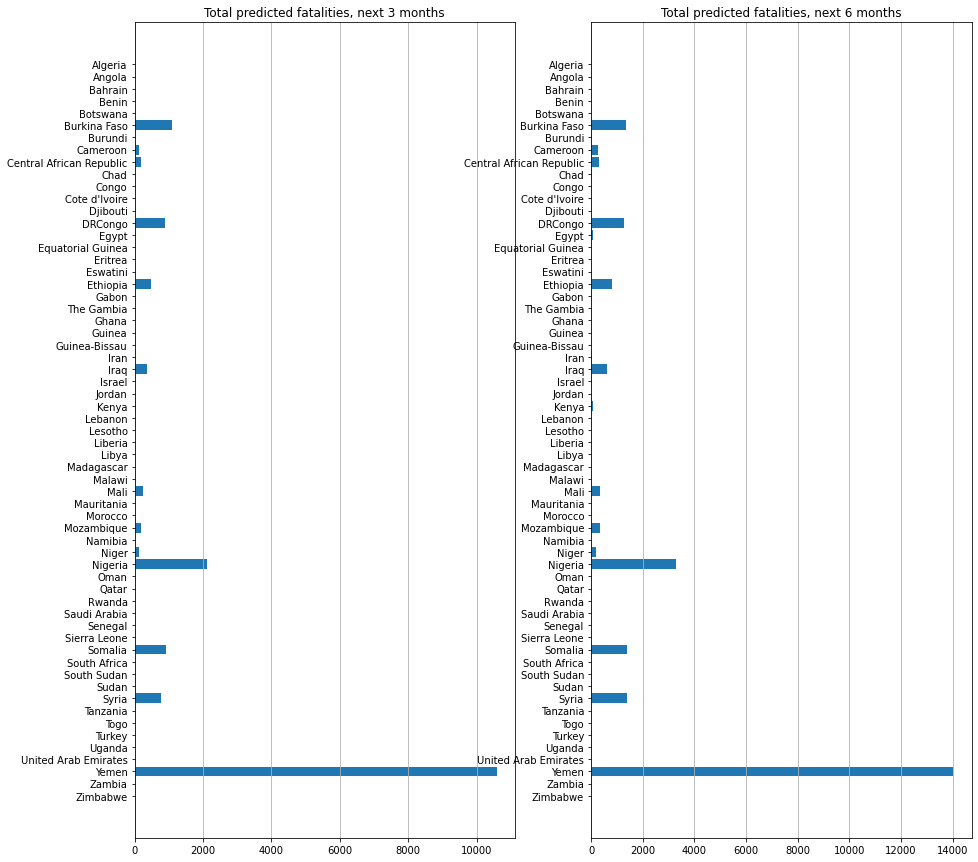

In [30]:
# Bar chart, fatalities next 3/6/12/36 months
labels3 = totals3_df['Country']
sizes3 = totals3_df['Fatalities']

labels6 = totals6_df['Country']
sizes6 = totals6_df['Fatalities']

labels12 = totals12_df['Country']
sizes12 = totals12_df['Fatalities']

labels36 = totals36_df['Country']
sizes36 = totals36_df['Fatalities']

# Figure for 12, 36 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.barh(width=sizes12, y=labels12)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.grid(axis = 'x')
ax2.barh(width=sizes36, y=labels36)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.grid(axis = 'x')

ax1.set_title('Total predicted fatalities, next 12 months')
ax2.set_title('Total predicted fatalities, next 36 months')

#plt.title('Predicted fatalities')

filename = path + 'TotalsBar_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsBar_12_36_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

# Figure for 3, 6 months into the future

fig1,(ax1,ax2) = plt.subplots(1,2,figsize=(15,15))

ax1.barh(width=sizes3, y=labels3)
ax1.invert_yaxis()  # labels read top-to-bottom
ax1.grid(axis = 'x')
ax2.barh(width=sizes6, y=labels6)
ax2.invert_yaxis()  # labels read top-to-bottom
ax2.grid(axis = 'x')

ax1.set_title('Total predicted fatalities, next 3 months')
ax2.set_title('Total predicted fatalities, next 6 months')

#plt.title('Predicted fatalities')

filename = path + 'TotalsBar_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
plt.savefig(filename, dpi=300)
if WriteToOverleaf:
    filename = overleafpath + 'TotalsBar_3_6_' + model['modelname'] + '_' + str(EndOfHistory) + '.png'
    plt.savefig(filename, dpi=300)

## Retrain the surrogate models

In [31]:
Datasets[10]['df']['vdem_v2x_libdem'].loc[544]

country_id
1      0.367
2      0.648
3      0.655
4      0.072
5      0.000
       ...  
242    0.314
243    0.241
244    0.168
245    0.082
246    0.059
Name: vdem_v2x_libdem, Length: 191, dtype: float64

s1 Conflict history
s1 Democracy
s1 Population
s1 Infant mortality
s1 Neighborhood conflict
s1 Topics: conflict and conflict stock
s2 Conflict history
s2 Democracy
s2 Population
s2 Infant mortality
s2 Neighborhood conflict
s2 Topics: conflict and conflict stock
s3 Conflict history
s3 Democracy
s3 Population
s3 Infant mortality
s3 Neighborhood conflict
s3 Topics: conflict and conflict stock
s4 Conflict history
s4 Democracy
s4 Population
s4 Infant mortality
s4 Neighborhood conflict
s4 Topics: conflict and conflict stock
s5 Conflict history
s5 Democracy
s5 Population
s5 Infant mortality
s5 Neighborhood conflict
s5 Topics: conflict and conflict stock
s6 Conflict history
s6 Democracy
s6 Population
s6 Infant mortality
s6 Neighborhood conflict
s6 Topics: conflict and conflict stock
s7 Conflict history
s7 Democracy
s7 Population
s7 Infant mortality
s7 Neighborhood conflict
s7 Topics: conflict and conflict stock
s8 Conflict history
s8 Democracy
s8 Population
s8 Infant mortality
s8 Neighborhood 

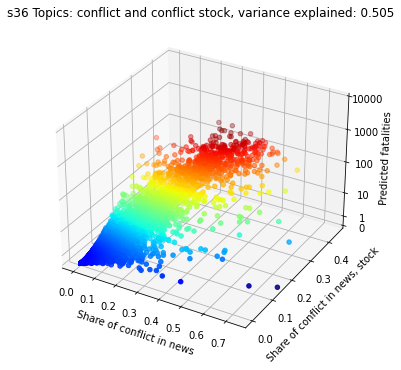

In [34]:
from cm_surrogatemodels import TrainSurrogateModels
SurrogateModelSteps = [1,3,6,36]
SurrogateModelSteps = steps
EndOfHistory_test = test_partitioner_dict['train'][1] 
Plotpath = Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Surrogate'


       
SurrogateModelList = TrainSurrogateModels(data_df = Datasets[10]['df'], 
                                          Ensemble_df = ensemble_test_df, 
                                          EndOfHistory = EndOfHistory_test, 
                                          SurrogateModelSteps = SurrogateModelSteps, 
                                          NumberOfMonths = 48,
                                          Plotpath = Plotpath)

In [35]:
predictors_df = Datasets[10]['df'].loc[EndOfHistory]

EnsembleList[0]['future_df_surrogates'] = EnsembleList[0]['future_df_calibrated'].copy()
# Initialize dataframe to hold surrogate model predictions:
for item in SurrogateModelList:
    if item['Step'] == 1:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        EnsembleList[0]['future_df_surrogates'][colname] = np.nan  
# Compute predictions for each step
for step in steps:
    month = EndOfHistory + step
#    print('Step',step,'Month',month)
    for item in SurrogateModelList:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        if item['Step']==step:
#            print('colname:',colname,'Step:',item['Step'], item['Columns'])
            EnsembleList[0]['future_df_surrogates'][colname].loc[month] = item['GAM'].predict(predictors_df[item['Columns']])

# Storing the surrogate model future predictions
for item in SurrogateModelList:
    if item['Step'] == 36:
        colname = item['Modelname'][item['Modelname'].index(' ') + 1:] # Remove first word (which is a step number)
        predstore_future = level +  '_surrogate_' + item['Shortname'] + '_f' + str(EndOfHistory)
        print('Storing surrogate model predictions for model',colname, 'as:',predstore_future)
        predictions_to_store = pd.DataFrame(EnsembleList[0]['future_df_surrogates'][colname])
        predictions_to_store.forecasts.set_run(run_id)
        predictions_to_store.forecasts.to_store(name=predstore_future, overwrite = True) 



Storing surrogate model predictions for model Conflict history as: cm_surrogate_CH_f505
Storing surrogate model predictions for model Democracy as: cm_surrogate_Dem_f505
Storing surrogate model predictions for model Population as: cm_surrogate_Pop_f505
Storing surrogate model predictions for model Infant mortality as: cm_surrogate_IMR_f505
Storing surrogate model predictions for model Neighborhood conflict as: cm_surrogate_NCH_f505
Storing surrogate model predictions for model Topics: conflict and conflict stock as: cm_surrogate_Topic10_f505


In [37]:
# Mapping

predictors_df = Datasets[10]['df'].loc[EndOfHistory]
predictors_df_3m = Datasets[10]['df'].loc[EndOfHistory-3]

path = Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Surrogate'
surrogate_scale=[np.log1p(0),np.log1p(3),np.log1p(10), np.log1p(30), np.log1p(100), np.log1p(300)]

surrogate_scale_labels = ['', '','', '', '', '']

MapSteps = [1,3,6,12,36]
for model in SurrogateModelList:
    if model['Step'] in MapSteps:
        print(model['Modelname'], model['Columns'])

        df = predictors_df[model['Columns']]
        df[model['Predcolname']] = model['GAM'].predict(predictors_df[model['Columns']])
        gdf2 = gdf_base.copy()
        df = df.join(gdf2.set_index("country_id"))
        gdf3 = gpd.GeoDataFrame(df, geometry="geom")
        Predcolname = model['Predcolname']
        step = model['Step']
        TargetMonth = EndOfHistory+step

        m=Mapper2(
        width=10,
        height=10,
        frame_on=True,
        title='Surrogate model ' + model['Modelname'] + ' predictions as of ' + vid2date(TargetMonth) + ', ' + str(step) + ' months after last month with data',
        bbox=[-18.5, 64.0, -35.5, 43.0], 
        ).add_layer(
        gdf=gdf3,
        map_scale=surrogate_scale,
        cmap="rainbow",
        edgecolor="black",
        linewidth=0.5,
        column=model['Predcolname'], 
        inform_colorbar=True
        )
        m.cbar.set_ticks(surrogate_scale)
        m.cbar.set_ticklabels(surrogate_scale_labels)

        m.save(f'{path}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')
        if WriteToOverleaf:
            m.save(f'{overleafpath}cm_surrogate_{Predcolname}_small_scale_{EndOfHistory}_{TargetMonth}.png')


s1 Conflict history ['ln_ged_sb_dep']
s1 Democracy ['vdem_v2x_libdem']
s1 Population ['wdi_sp_pop_totl']
s1 Infant mortality ['wdi_sp_dyn_imrt_in']
s1 Neighborhood conflict ['splag_1_decay_ged_sb_5']
s1 Topics: conflict and conflict stock ['ste_theta10', 'ste_theta10_stock']
s3 Conflict history ['ln_ged_sb_dep']
s3 Democracy ['vdem_v2x_libdem']
s3 Population ['wdi_sp_pop_totl']
s3 Infant mortality ['wdi_sp_dyn_imrt_in']
s3 Neighborhood conflict ['splag_1_decay_ged_sb_5']
s3 Topics: conflict and conflict stock ['ste_theta10', 'ste_theta10_stock']
s6 Conflict history ['ln_ged_sb_dep']
s6 Democracy ['vdem_v2x_libdem']
s6 Population ['wdi_sp_pop_totl']
s6 Infant mortality ['wdi_sp_dyn_imrt_in']
s6 Neighborhood conflict ['splag_1_decay_ged_sb_5']
s6 Topics: conflict and conflict stock ['ste_theta10', 'ste_theta10_stock']
s12 Conflict history ['ln_ged_sb_dep']
s12 Democracy ['vdem_v2x_libdem']
s12 Population ['wdi_sp_pop_totl']
s12 Infant mortality ['wdi_sp_dyn_imrt_in']
s12 Neighborhood con

# Changes to 3- and 6-month forecasts, and since last actual observation

In [38]:
# Reading in data for mapping
# Predictions now and then
predstore_then = level +  '_' + EnsembleList[0]['modelname'] + '_f' + str(EndOfHistory-3)

df_now = EnsembleList[0]['future_df_calibrated'].copy()
try:
    df_then = pd.DataFrame.forecasts.read_store(run=run_id, name=predstore_then)
except:
    print('Trouble reading forecasts issued three months ago')
    
# Actuals
qs = (Queryset("hh_fatalities_ged_ln_ultrashort", "country_month"))
df_lastobserved = qs.fetch().astype(float)

pr_45_cm_genetic_ensemble_f502.parquet
Trouble reading forecasts issued three months ago
 .    

In [ ]:
ViewsMetadata().with_name('ensemble_f506').fetch()

In [ ]:
# Compute log of mean non-logged fatalities, past six months
df_observed = df_lastobserved.loc[EndOfHistory]
df_observed['ged_sb_0'] = np.expm1(df_observed['ln_ged_sb'])
df_observed['ged_sum'] = df_observed['ged_sb_0']
for t in [1,2,3,4,5]:
    colname = 'ged_sb_' + str(t)
    df_observed[colname] = np.expm1(df_lastobserved.loc[EndOfHistory-t]['ln_ged_sb'])
    df_observed['ged_sum'] = df_observed['ged_sum'] + df_observed[colname]
df_observed['ln_ged_sum'] = np.log1p(df_observed['ged_sum']/6)
#df_observed.tail(20)

In [ ]:
StepsForward = [
{
    'Step': 3,
    'df_now': df_now.loc[EndOfHistory + 3],
    'df_then': df_then.loc[EndOfHistory - 3 + 3]
},
{
    'Step': 6,
    'df_now': df_now.loc[EndOfHistory + 6],
    'df_then': df_then.loc[EndOfHistory - 3 + 6]
},
    {
    'Step': 12,
    'df_now': df_now.loc[EndOfHistory + 12],
    'df_then': df_then.loc[EndOfHistory - 3 + 12]
},
    {
    'Step': 36,
    'df_now': df_now.loc[EndOfHistory + 36],
    'df_then': df_then.loc[EndOfHistory - 3 + 36]
},
]
engine = sa.create_engine(source_db_path)
#predictors_df = data_vdem_short.loc[EndOfHistory]
#predictors_df_3m = data_vdem_short.loc[EndOfHistory-3]

for s in StepsForward:
    s['df_now'].rename(columns={'step_combined':'Now'}, inplace=True)
    s['df_then'].rename(columns={'step_combined':'Then'}, inplace=True)
    s['df'] = pd.concat([s['df_now'],s['df_then'],df_observed['ln_ged_sum']],axis=1)
    s['df']['Change_in_prediction'] = s['df']['Now']-s['df']['Then']
    s['df']['Change_since_last_observed'] = s['df']['Now']-s['df']['ln_ged_sum']
    
    # Surrogate model change
    for sm in SurrogateModelList:
        if sm['Step'] == s['Step']:
            s['sdf'] = predictors_df[sm['Columns']]
            s['sdf'][sm['Predcolname']] = sm['GAM'].predict(predictors_df[sm['Columns']])
            s['sdf_3m'] = predictors_df_3m[sm['Columns']]
            s['sdf_3m'][sm['Predcolname']] = sm['GAM'].predict(predictors_df_3m[sm['Columns']])
            print(sm['Step'],sm['Predcolname'])
            dfcolname = 's_pred_m' + sm['Shortname'] + '_ch3m' 
            s['df'][dfcolname] = s['sdf'][sm['Predcolname']] - s['sdf_3m'][sm['Predcolname']]
    
    s['gdf'] = gpd.GeoDataFrame.from_postgis(
        "SELECT id as country_id, in_africa, in_me, geom FROM prod.country", 
        engine, 
        geom_col='geom'
    )
    s['gdf'] = s['gdf'].to_crs(4326)

    s['gdf_t'] = s['df'].join(s['gdf'].set_index("country_id"))
    s['gdf'] = gpd.GeoDataFrame(s['gdf_t'], geometry="geom")
    
    

In [ ]:
StepsForward[3]['gdf'].describe()

In [ ]:
SurrogateModelList

In [ ]:
delta = 3

path = Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Change maps'

tickvalues=np.array([-300,-30,-3,3,30,300])
ticklabels=[str(tv) for tv in tickvalues]

tickvalues=np.sign(tickvalues)*np.log1p(np.abs(tickvalues)+1)
#print(tickvalues)
tickvalues = np.array([-83,-80,-50,-20,0,20,50,100,200,500])
ticklabels=[str(tv) for tv in tickvalues]
ticklabels[0] = ""
tickvalues = np.log((100+tickvalues)/100)


t0s=range(506,508) # From start of month A, to start of (but not including) month B
bbox="africa_middle_east"
cmap='bwr'#'rainbow'
ColumnsToPlot = ['Change_in_prediction',
                 'Change_since_last_observed',
                 's_pred_mCH_ch3m',
                 's_pred_mNCH_ch3m',
                 's_pred_mDem_ch3m',
                 's_pred_mIMR_ch3m',
                # 's_pred_mTopics10_ch3m',
                ]


for s in StepsForward:
    print('Step:',s['Step'])
    for column in ColumnsToPlot:
        titlestring=''
        plot = ViewsMap(
            width=10,
            label=f"{column}, s= {s['Step']}",
            title="",
            scale=None,
            bbox=bbox
        ).add_layer(
            s['gdf'],
            edgecolor="black",
            linewidth=0.2,
            column=column,
        inform_colorbar=True,
        cmap=cmap,
        vmin=tickvalues[0],vmax=tickvalues[-1]
    )

        ax=plot.ax
        fg=s['gdf'].plot(ax=ax,edgecolor='black',linewidth=0.2,facecolor='None')
       # fg=gdf_c.plot(ax=ax,edgecolor='gray',linewidth=1.0,facecolor='None')
        figure=plot.fig
        fontdict={'fontsize':20}
        fig=plot.fig

        plot.cbar.set_ticks(tickvalues)
        plot.cbar.set_ticklabels(ticklabels)
        if abs(delta)==1:
            mnth='month'
        else:
            mnth='months'
        plot.cbar.set_label(f'Percent change in {column} over past '+str(delta)+' '+mnth)
        plot.save(path+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')
        if WriteToOverleaf:
            plot.save(overleafpath+column+str(s['Step'])+'_r' + str(EndOfHistory) +'.png')

In [ ]:
s['gdf'].head()

# Uncertainty of predictions

In [40]:
# Train model to transform predictions from  fatalities to multiclass probabilities
from sklearn.linear_model import LogisticRegression
# Classes are: 
# 0: Less than 0.5
# 1: 0.5-10
# 2: 10-100
# 3: 100-1000
# 4: 1000 +

multi_classifiers = []
df_future = EnsembleList[0]['future_df_calibrated'].copy()
for cls in [0,1,2,3,4]:
    df_future[f'multi_{cls}_logit'] = np.nan

for step in steps:
    Month = EndOfHistory + step
    X = np.array(ensemble_test_df[f'step_pred_{step}'])
    X = X.reshape(-1,1)
    # Multiclass
    y_multi = np.array(ensemble_test_df['ged_multi']).reshape(-1, 1)
    multi_clf = LogisticRegression(random_state=0).fit(X, y_multi)
    multi_classifiers.append(multi_clf)
    X_future = np.array(df_future['step_combined'].loc[Month]).reshape(-1,1)
    p_multi = multi_clf.predict_proba(X_future)
    for cls in [0,1,2,3,4]:
        df_future[f'multi_{cls}_logit'].loc[Month] = p_multi[:,cls]

        
df_future.describe()

feature,step_combined,multi_0_logit,multi_1_logit,multi_2_logit,multi_3_logit,multi_4_logit
count,6876.000000,6.876000e+03,6876.000000,6876.000000,6876.000000,6.876000e+03
mean,0.739655,8.444608e-01,0.053472,0.081112,0.019380,1.574722e-03
std,1.410582,2.990006e-01,0.078893,0.183917,0.067145,2.076893e-02
min,-0.016909,2.741871e-14,0.000002,0.001705,0.000002,4.159129e-12
25%,0.038400,9.506995e-01,0.015679,0.004367,0.000048,1.383365e-09
50%,0.094451,9.767352e-01,0.017475,0.005978,0.000106,3.365197e-09
75%,0.531840,9.796812e-01,0.032617,0.014341,0.000306,1.798092e-08
max,8.200486,9.843461e-01,0.441196,0.767818,0.680483,8.922472e-01


In [41]:
# Some uncertainty calculations
#October 2022 (514)
CL = [
    ('Ethiopia',57,4.114,0.0025217435284640467,0.167910951747582,0.7099704830039664,0.11880956751085855,0.0007872542091291349),
    ('Kenya',237,2.202,0.27979924123523675,0.37093623451842744,0.3384779788333302,0.010780625441912769,5.919971092604168e-06),
    ('Nigeria',79,5.891,1.1834522019553202e-05,0.030050677139008334,0.5285925149395453,0.41358824669460437,0.027756726704822352),
    ('South Africa',163,0.103,0.9794051664145842,0.017598332401191557,0.0029811455728619585,1.5355064175926178e-05,5.471865662986281e-10),
    ('South Sudan',246,1.782,0.5171316993204126,0.2898656997683062,0.18882479925510778,0.004176475005701126,1.3266504722650525e-06),
    ('Sudan',245,1.971,0.40522067161826564,0.3345539054572092,0.2536133366482648,0.006609400618818177,2.6856574423520527e-06),
    ('Syria',220,4.818,0.0003291633453796389,0.09280289507829718,0.6904155754185439,0.21292026113053514,0.0035321050272440497),
    ('Tanzania',242,0.741,0.9214126374988004,0.06115410932346314,0.017278449601019125,0.0001547909157059216,1.2661011272757968e-08),
    ('Yemen',124,6.352,2.556591139139699e-06,0.016708050733656395,0.42553124292260786,0.4969226339388311,0.06083551581376548),
    ('Zimbabwe',158,0.050,0.9816070866339232,0.015813575350686226,0.0025667146500692674,1.2622945665883365e-05,4.196556261097782e-10),
]

for C in CL: 
    print(C[0],C[2],np.expm1(C[2]))
    print('< 0.5:',C[3])
    print('0.5-10:',C[4])
    print('10-100:',C[5])
    print('100-1000:',C[6])
    print('1000+:',C[7])
    print('****')
    

Ethiopia 4.114 60.19099266439019
< 0.5: 0.0025217435284640467
0.5-10: 0.167910951747582
10-100: 0.7099704830039664
100-1000: 0.11880956751085855
1000+: 0.0007872542091291349
****
Kenya 2.202 8.043081588499359
< 0.5: 0.27979924123523675
0.5-10: 0.37093623451842744
10-100: 0.3384779788333302
100-1000: 0.010780625441912769
1000+: 5.919971092604168e-06
****
Nigeria 5.891 360.7668704195498
< 0.5: 1.1834522019553202e-05
0.5-10: 0.030050677139008334
10-100: 0.5285925149395453
100-1000: 0.41358824669460437
1000+: 0.027756726704822352
****
South Africa 0.103 0.10849140907600723
< 0.5: 0.9794051664145842
0.5-10: 0.017598332401191557
10-100: 0.0029811455728619585
100-1000: 1.5355064175926178e-05
1000+: 5.471865662986281e-10
****
South Sudan 1.782 4.941727999051595
< 0.5: 0.5171316993204126
0.5-10: 0.2898656997683062
10-100: 0.18882479925510778
100-1000: 0.004176475005701126
1000+: 1.3266504722650525e-06
****
Sudan 1.971 6.1778507513686165
< 0.5: 0.40522067161826564
0.5-10: 0.3345539054572092
10-1

In [42]:
path = Mydropbox + f'DataReleases/MonthlyUpdates/{run_id}_{prod_id}/Uncertainty'

In [43]:
df_future.to_csv('Categorical_probabilities.csv')